#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/project1/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩
    - pandas, numpy,matplotlib,seaborn, joblib 을 로딩하고
    필요한 라이브러리를 로딩합니다.
    <br>(분류 모델에서는 이번에 RandomForestClassifier를 씁니다. 더 많은 분류 모델을 써도 됩니다!)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

# 추가
import math
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# (Jupyter) 시각화 한글폰트 설정을 위해 아래 코드를 실행하세요.
plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [3]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * features.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [8]:
# 주어진 데이터 셋을 불러오세요.
path = '../data/'
train_data = pd.read_csv(path + 'data01_train.csv')
test_data = pd.read_csv(path + 'data01_test.csv')
feature = pd.read_csv(path + 'features.csv')

In [9]:
#불필요한 칼럼을 삭제하세요.
train_data = train_data.drop(columns=['subject'])
test_data = test_data.drop(columns=['subject'])

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
# 전체 데이터의 행, 열 개수를 확인
display(train_data.shape)
display(test_data.shape)

(5881, 562)

(1471, 562)

In [ ]:
# 전체 데이터의 상위 5개 행 확인
display(train_data.head())
display(test_data.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [10]:
# 전체 데이터의 수치형 변수 분포 확인
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

summary = train_data[numeric_cols].describe().T
summary['skew'] = train_data[numeric_cols].skew()   # 왜도
summary['kurt'] = train_data[numeric_cols].kurt()   # 첨도
display(summary.head(10))

numeric_cols2 = test_data.select_dtypes(include=['int64', 'float64']).columns

summary2 = test_data[numeric_cols2].describe().T
summary2['skew'] = test_data[numeric_cols2].skew()   # 왜도
summary2['kurt'] = test_data[numeric_cols2].kurt()   # 첨도
display(summary2.head(10))

,count,mean,std,min,25%,50%,75%,max,skew,kurt
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000,-1.992708,25.270158
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000,2.020631,170.002842
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000,1.709861,90.980485
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000,0.666620,-0.880765
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238,0.401020,-1.448083
tBodyAcc-std()-Z,5881.0,-0.604058,0.417319,-0.999667,-0.980127,-0.856352,-0.262690,1.000000,0.676910,-0.645706
tBodyAcc-mad()-X,5881.0,-0.628151,0.424345,-1.000000,-0.993602,-0.948501,-0.291138,1.000000,0.717206,-0.708937
tBodyAcc-mad()-Y,5881.0,-0.525944,0.485115,-0.999419,-0.977865,-0.849266,-0.068857,0.967664,0.404094,-1.439999
tBodyAcc-mad()-Z,5881.0,-0.605374,0.413043,-1.000000,-0.980112,-0.849896,-0.268539,1.000000,0.638990,-0.770888
tBodyAcc-max()-X,5881.0,-0.465490,0.544995,-1.000000,-0.936067,-0.878729,-0.013690,1.000000,0.620688,-1.139105


,count,mean,std,min,25%,50%,75%,max,skew,kurt
tBodyAcc-mean()-X,1471.0,0.273198,0.079989,-1.000000,0.263787,0.277322,0.288058,0.631510,-6.866798,99.738427
tBodyAcc-mean()-Y,1471.0,-0.017281,0.045957,-1.000000,-0.024792,-0.017187,-0.010238,0.359587,-6.526640,168.931137
tBodyAcc-mean()-Z,1471.0,-0.108123,0.049082,-0.418354,-0.120733,-0.108124,-0.096606,0.543939,2.233829,34.031729
tBodyAcc-std()-X,1471.0,-0.614634,0.448480,-0.999717,-0.992669,-0.952426,-0.245405,0.899922,0.721920,-0.800044
tBodyAcc-std()-Y,1471.0,-0.515427,0.506094,-0.999873,-0.979082,-0.867309,-0.030639,0.782590,0.425783,-1.470720
tBodyAcc-std()-Z,1471.0,-0.607533,0.424243,-1.000000,-0.981070,-0.869890,-0.260223,0.931308,0.752295,-0.479046
tBodyAcc-mad()-X,1471.0,-0.639950,0.422994,-0.999867,-0.993498,-0.958705,-0.297260,0.950758,0.779584,-0.579333
tBodyAcc-mad()-Y,1471.0,-0.530760,0.489381,-1.000000,-0.979214,-0.873891,-0.058824,0.602458,0.416484,-1.498982
tBodyAcc-mad()-Z,1471.0,-0.609256,0.418536,-0.999879,-0.980659,-0.863451,-0.256657,0.784041,0.698525,-0.682319
tBodyAcc-max()-X,1471.0,-0.481055,0.542756,-0.948723,-0.936791,-0.890491,-0.030692,0.821218,0.670889,-1.091575


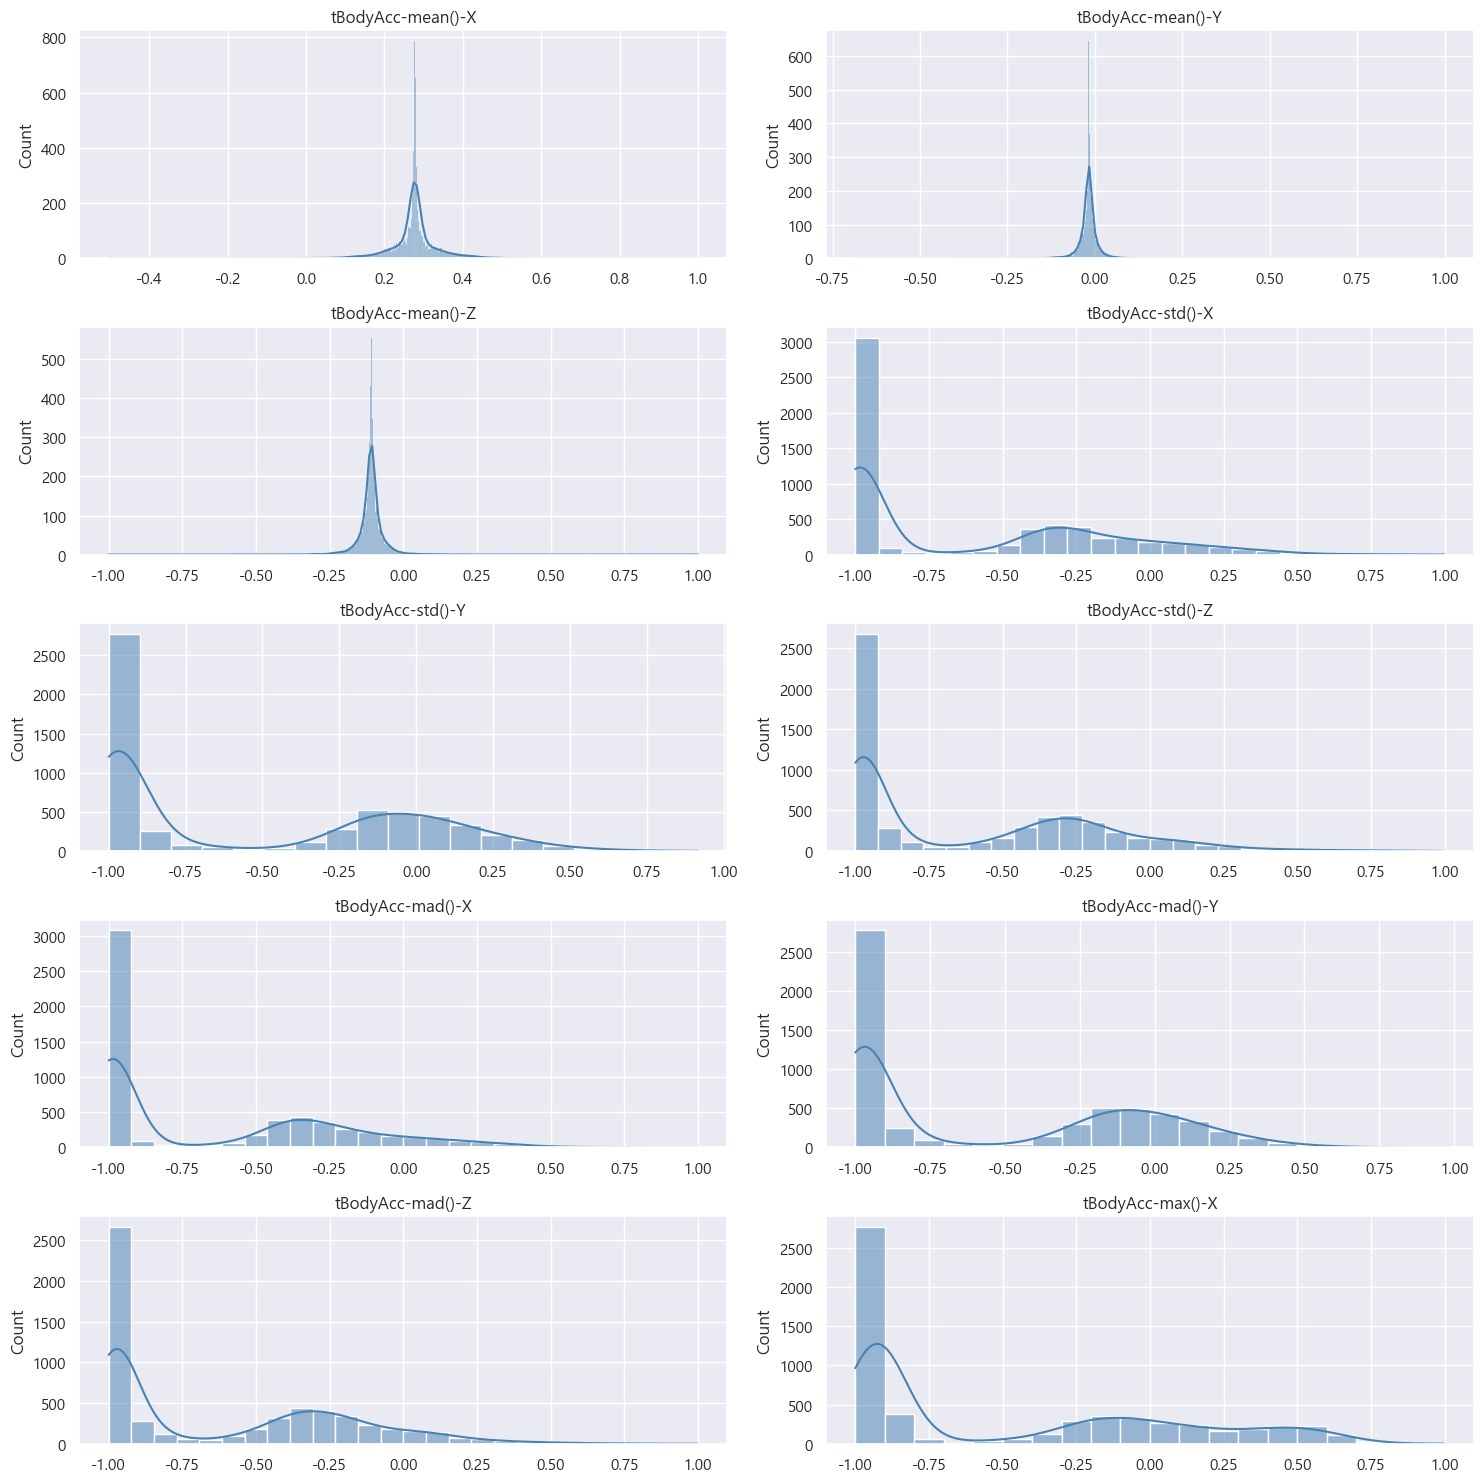

In [11]:
# 출력 개수
index = 0
size = 10

start = index
end = index + size
if end > len(numeric_cols): 
    end = len(numeric_cols)

# top_features 추출
top_features = numeric_cols[start:end]

# subplot 행, 열 계산 (2열 기준)
num_features = len(top_features)
rows = math.ceil(num_features / 2)  # 2열로 배치

# 시각화
plt.figure(figsize=(15, rows * 3))
for i, col in enumerate(top_features):
    plt.subplot(rows, 2, i + 1)
    sns.histplot(train_data[col], kde=True, color='steelblue')
    plt.title(col)
    plt.xlabel('')
plt.tight_layout()
plt.show()


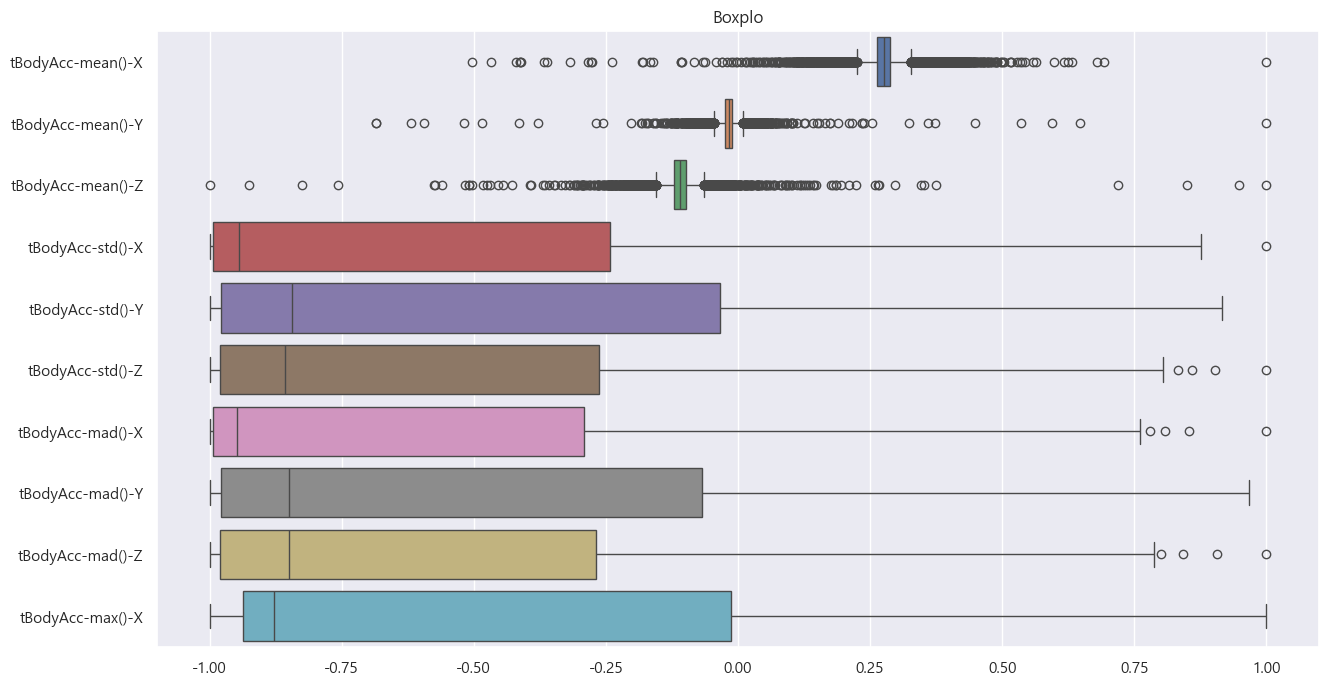

In [12]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=train_data[top_features], orient='h')
plt.title("Boxplo")
plt.show()

In [13]:
# 전체 데이터의 모든 변수 확인
print('train_data')
for col in train_data.columns:
    print(col, train_data[col].dtype, train_data[col].isnull().sum())

print('\n\ntest_data')
for col in test_data.columns:
    print(col, test_data[col].dtype, test_data[col].isnull().sum())

train_data
tBodyAcc-mean()-X float64 0
tBodyAcc-mean()-Y float64 0
tBodyAcc-mean()-Z float64 0
tBodyAcc-std()-X float64 0
tBodyAcc-std()-Y float64 0
tBodyAcc-std()-Z float64 0
tBodyAcc-mad()-X float64 0
tBodyAcc-mad()-Y float64 0
tBodyAcc-mad()-Z float64 0
tBodyAcc-max()-X float64 0
tBodyAcc-max()-Y float64 0
tBodyAcc-max()-Z float64 0
tBodyAcc-min()-X float64 0
tBodyAcc-min()-Y float64 0
tBodyAcc-min()-Z float64 0
tBodyAcc-sma() float64 0
tBodyAcc-energy()-X float64 0
tBodyAcc-energy()-Y float64 0
tBodyAcc-energy()-Z float64 0
tBodyAcc-iqr()-X float64 0
tBodyAcc-iqr()-Y float64 0
tBodyAcc-iqr()-Z float64 0
tBodyAcc-entropy()-X float64 0
tBodyAcc-entropy()-Y float64 0
tBodyAcc-entropy()-Z float64 0
tBodyAcc-arCoeff()-X,1 float64 0
tBodyAcc-arCoeff()-X,2 float64 0
tBodyAcc-arCoeff()-X,3 float64 0
tBodyAcc-arCoeff()-X,4 float64 0
tBodyAcc-arCoeff()-Y,1 float64 0
tBodyAcc-arCoeff()-Y,2 float64 0
tBodyAcc-arCoeff()-Y,3 float64 0
tBodyAcc-arCoeff()-Y,4 float64 0
tBodyAcc-arCoeff()-Z,1 float

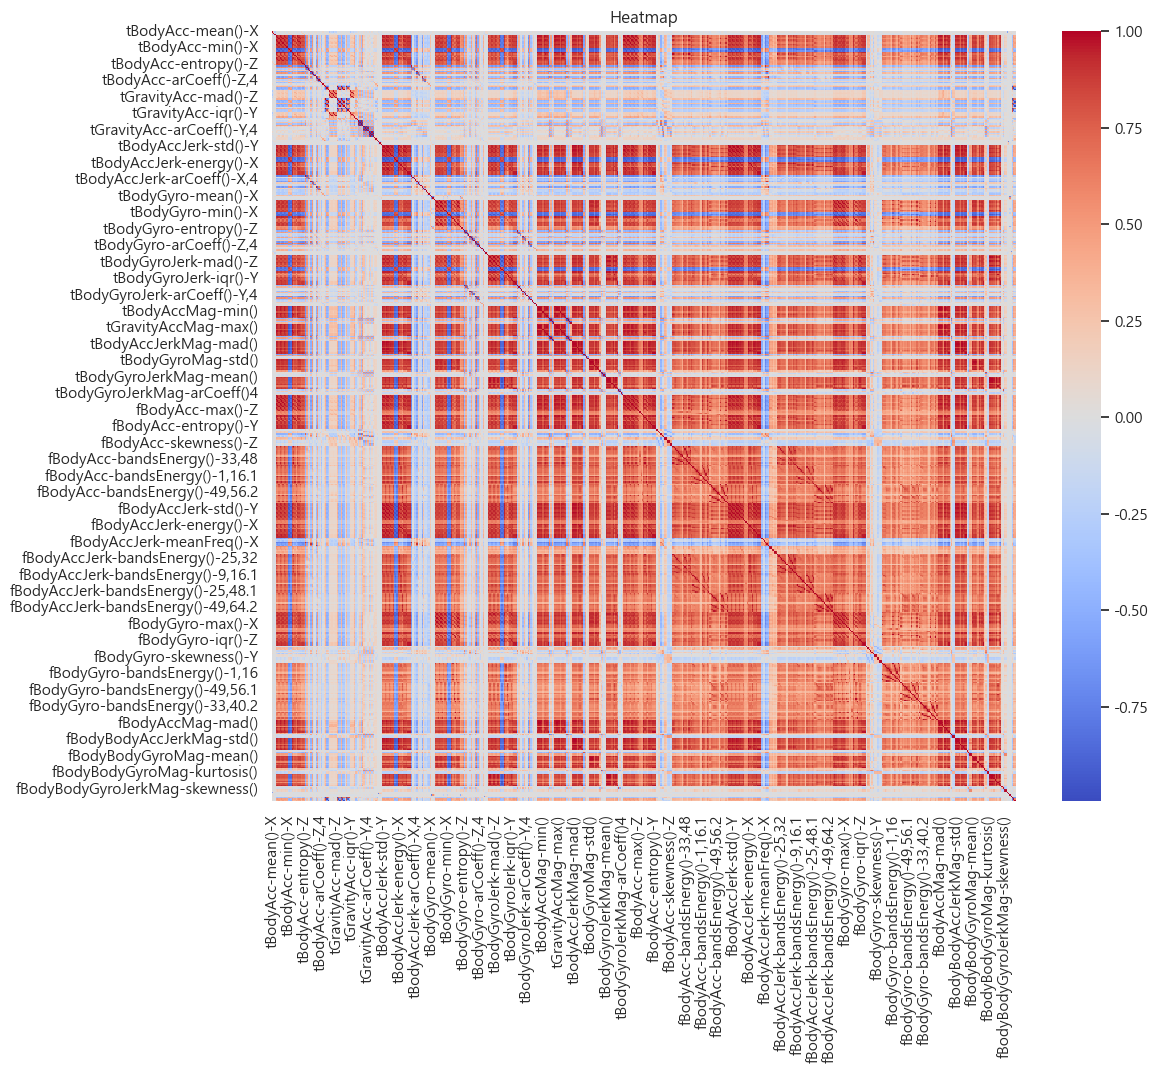

In [ ]:
#(추가) 다양하게 기본 정보들을 확인하세요!
numeric_df = train_data[numeric_cols] 
plt.figure(figsize=(12, 10))
corr = numeric_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Heatmap")
plt.show()

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
# Activity 에 대해서 단변량 분석을 시행합니다. (범주별 빈도수, 종류, 비율, 시각화도 해보기!)
activity_classes = train_data['Activity'].unique()
print("Activity 종류:", activity_classes)
print("총 개수:", len(activity_classes))

Activity 종류: ['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']
총 개수: 6


In [ ]:
# 범주별 빈도수
activity_counts = train_data['Activity'].value_counts()
print("범주별 빈도수:\n", activity_counts)

범주별 빈도수:
 Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64


In [ ]:
# 범주별 비율 (%)
activity_ratio = train_data['Activity'].value_counts(normalize=True) * 100
print("범주별 비율(%):\n", activity_ratio.round(2))

범주별 비율(%):
 Activity
LAYING                18.96
STANDING              18.48
SITTING               17.55
WALKING               16.97
WALKING_UPSTAIRS      14.59
WALKING_DOWNSTAIRS    13.45
Name: proportion, dtype: float64


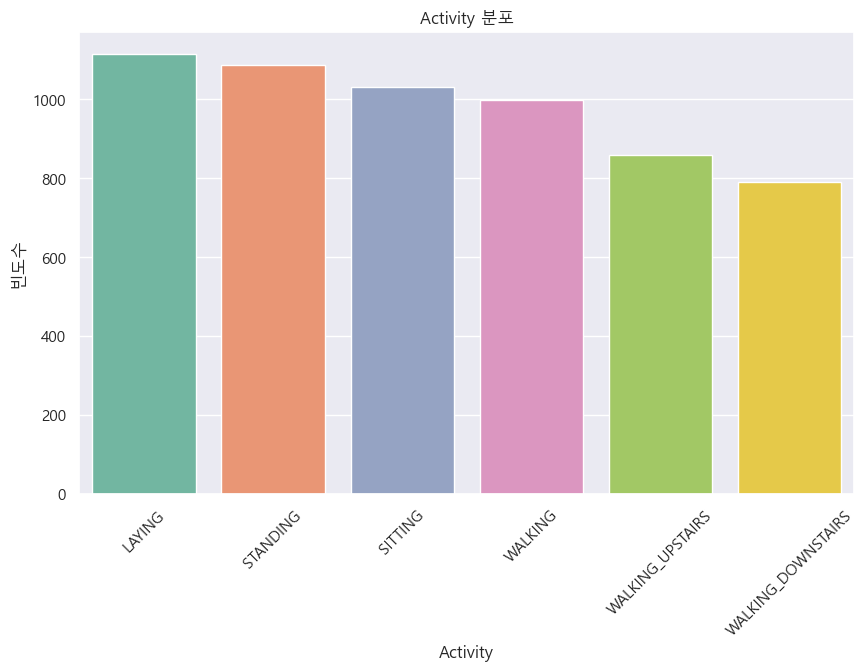

In [ ]:
# 비율 시각화
plt.figure(figsize=(10,6))
sns.countplot(x='Activity', data=train_data, palette='Set2', order=activity_counts.index)
plt.title("Activity 분포")
plt.xlabel("Activity")
plt.ylabel("빈도수")
plt.xticks(rotation=45)
plt.show()

### (3) 센서 그룹 데이터: features
# 수정하기

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [23]:
# 센서 그룹 데이터의 'sensor'변수의 값 확인
print(feature['sensor'].unique())
print(feature['sensor'].value_counts())

['tBodyAcc' 'tGravityAcc' 'tBodyAccJerk' 'tBodyGyro' 'tBodyGyroJerk'
 'tBodyAccMag' 'tGravityAccMag' 'tBodyAccJerkMag' 'tBodyGyroMag'
 'tBodyGyroJerkMag' 'fBodyAcc' 'fBodyAccJerk' 'fBodyGyro' 'fBodyAccMag'
 'fBodyBodyAccJerkMag' 'fBodyBodyGyroMag' 'fBodyBodyGyroJerkMag' 'angle']
sensor
fBodyGyro               79
fBodyAcc                79
fBodyAccJerk            79
tBodyAcc                40
tBodyAccJerk            40
tBodyGyro               40
tBodyGyroJerk           40
tGravityAcc             40
fBodyBodyGyroJerkMag    13
fBodyBodyGyroMag        13
fBodyBodyAccJerkMag     13
fBodyAccMag             13
tBodyGyroJerkMag        13
tBodyGyroMag            13
tBodyAccJerkMag         13
tGravityAccMag          13
tBodyAccMag             13
angle                    7
Name: count, dtype: int64


In [24]:
# 센서 그룹 데이터의 'agg'변수의 값 확인
print(feature['agg'].unique())
print(feature['agg'].value_counts())

['mean()' 'std()' 'mad()' 'max()' 'min()' 'sma()' 'energy()' 'iqr()'
 'entropy()' 'arCoeff()' 'correlation()' 'arCoeff()1' 'arCoeff()2'
 'arCoeff()3' 'arCoeff()4' 'maxInds' 'meanFreq()' 'skewness()'
 'kurtosis()' 'bandsEnergy()' 'tBodyAccMean' 'tBodyAccJerkMean'
 'tBodyGyroMean' 'tBodyGyroJerkMean' 'X' 'Y' 'Z']
agg
bandsEnergy()        126
arCoeff()             60
mean()                33
mad()                 33
max()                 33
min()                 33
energy()              33
iqr()                 33
entropy()             33
std()                 33
sma()                 17
correlation()         15
meanFreq()            13
kurtosis()            13
skewness()            13
maxInds               13
arCoeff()3             5
arCoeff()4             5
arCoeff()2             5
arCoeff()1             5
tBodyAccMean           1
tBodyAccJerkMean       1
tBodyGyroMean          1
tBodyGyroJerkMean      1
X                      1
Y                      1
Z                      1
Name: co

In [25]:
# 센서 그룹 데이터의 'axis'변수의 값 확인
print(feature['axis'].unique())
print(feature['axis'].value_counts())

['X' 'Y' 'Z' nan 'X,1' 'X,2' 'X,3' 'X,4' 'Y,1' 'Y,2' 'Y,3' 'Y,4' 'Z,1'
 'Z,2' 'Z,3' 'Z,4' 'X,Y' 'X,Z' 'Y,Z' '1,8' '9,16' '17,24' '25,32' '33,40'
 '41,48' '49,56' '57,64' '1,16' '17,32' '33,48' '49,64' '1,24' '25,48'
 '1,8.1' '9,16.1' '17,24.1' '25,32.1' '33,40.1' '41,48.1' '49,56.1'
 '57,64.1' '1,16.1' '17,32.1' '33,48.1' '49,64.1' '1,24.1' '25,48.1'
 '1,8.2' '9,16.2' '17,24.2' '25,32.2' '33,40.2' '41,48.2' '49,56.2'
 '57,64.2' '1,16.2' '17,32.2' '33,48.2' '49,64.2' '1,24.2' '25,48.2'
 'gravity' 'gravityMean']
axis
X              76
Y              76
Z              76
gravityMean     6
X,2             5
               ..
25,32.1         2
17,24.1         2
1,8.1           2
9,16.1          2
gravity         1
Name: count, Length: 62, dtype: int64


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [10]:
# 데이터 분할을 위한 전처리
X_train = train_data.drop(columns=['Activity'])
y_train = train_data['Activity']

X_test = test_data.drop(columns=['Activity'])
y_test = test_data['Activity']

#### 2) 모델링

In [11]:
#생성
rf_model_activity = RandomForestClassifier(random_state=42, n_jobs=-1)

#학습
rf_model_activity.fit(X_train, y_train)

#평가
y_pred = rf_model_activity.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:", acc)

# 상세 리포트
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9782460910944936

Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.96      0.95      0.95       254
          STANDING       0.96      0.96      0.96       287
           WALKING       0.99      0.98      0.99       228
WALKING_DOWNSTAIRS       0.99      0.98      0.99       195
  WALKING_UPSTAIRS       0.97      0.99      0.98       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



#### 3) 변수 중요도 추출

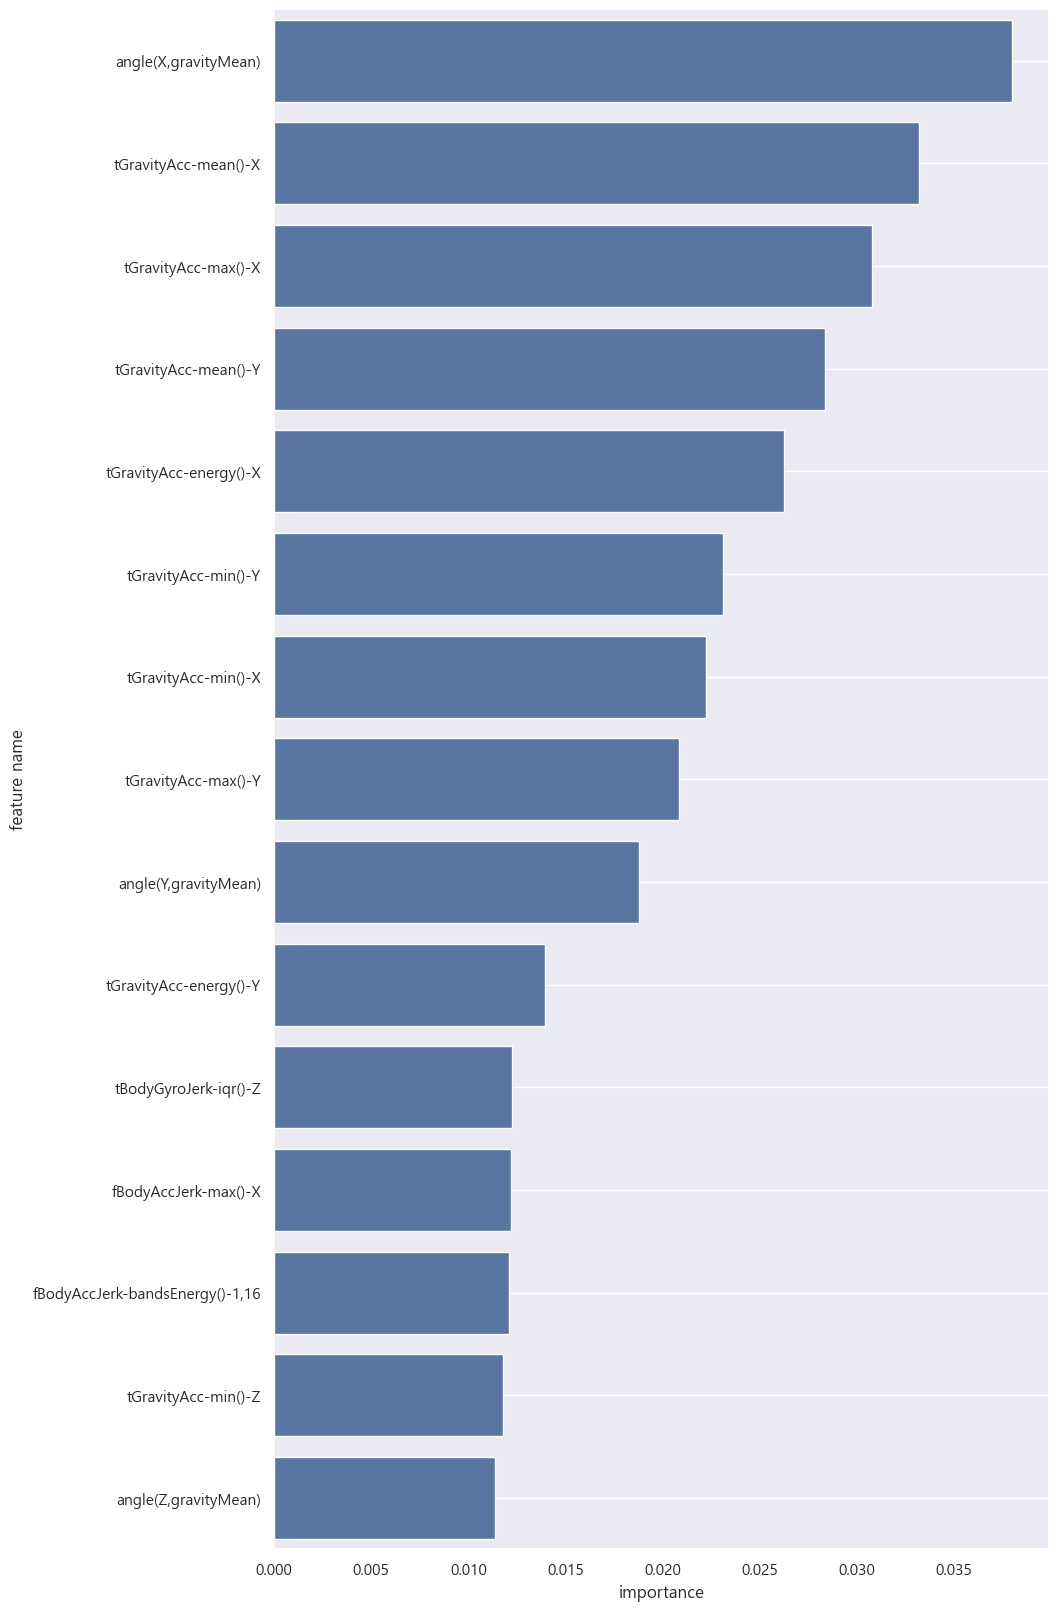

In [ ]:
# 변수 중요도 추출(시각화로 나타내기)
n_top = 15
feature_importances = rf_model_activity.feature_importances_
fi_df = plot_feature_importance(feature_importances, X_train.columns, topn=n_top)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
# 중요도 상위 top 5
fi_df_sorted = fi_df.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)

print("상위 5개 feature:")
print(fi_df_sorted.head(5))

상위 5개 feature:
             feature_name  feature_importance
0    angle(X,gravityMean)            0.038026
1    tGravityAcc-mean()-X            0.033202
2     tGravityAcc-max()-X            0.030811
3    tGravityAcc-mean()-Y            0.028376
4  tGravityAcc-energy()-X            0.026269


In [ ]:
# 중요도 하위 top 5
print("\n하위 5개 feature:")
print(fi_df_sorted.tail(5))


하위 5개 feature:
                       feature_name  feature_importance
10            tBodyGyroJerk-iqr()-Z            0.012236
11             fBodyAccJerk-max()-X            0.012180
12  fBodyAccJerk-bandsEnergy()-1,16            0.012092
13              tGravityAcc-min()-Z            0.011793
14             angle(Z,gravityMean)            0.011381


#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

In [ ]:
def plot_feature_kde(X, y, feature):
    """
    Parameters:
        - X : DataFrame, feature 데이터
        - y : Series, target 데이터
        - feature : str, 분석할 feature 이름
    """
    plt.figure(figsize=(6,4))
    for label in y.unique():
        sns.kdeplot(
            x=X[feature][y==label],
            label=label,
            fill=True,
            alpha=0.3
        )
    plt.title(f'{feature} vs Activity')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(False)    
    plt.gca().set_facecolor('white')
    plt.gcf().set_facecolor('white')
    sns.despine() 
    plt.show()

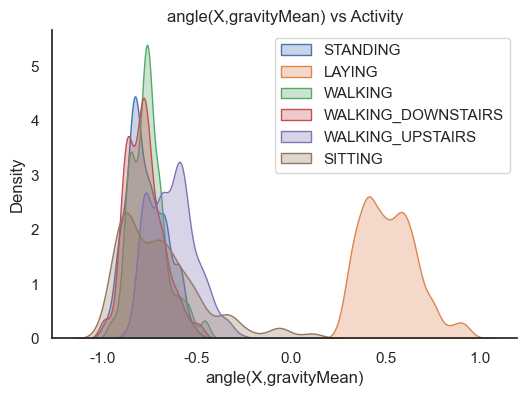

In [ ]:
# 1위 : angle(X,gravityMean) 
top_5_features = fi_df_sorted['feature_name'].head(5).tolist()
plot_feature_kde(X_train, y_train, top_5_features[0])

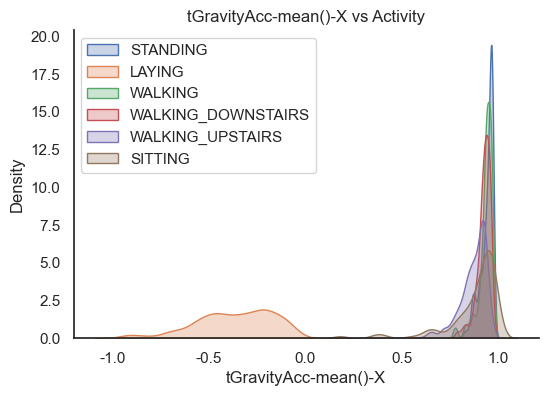

In [ ]:
# 2위: tGravityAcc-mean()-X
plot_feature_kde(X_train, y_train, top_5_features[1])

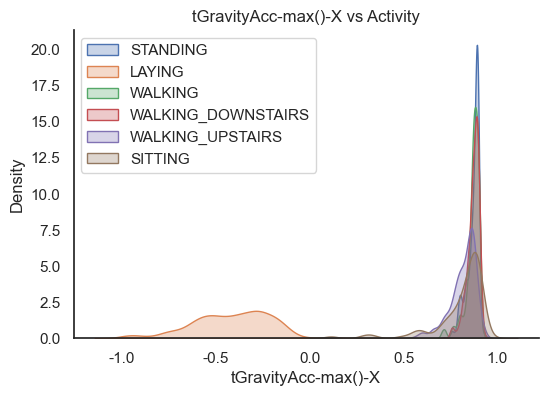

In [ ]:
# 3위: tGravityAcc-max()-X
plot_feature_kde(X_train, y_train, top_5_features[2])   

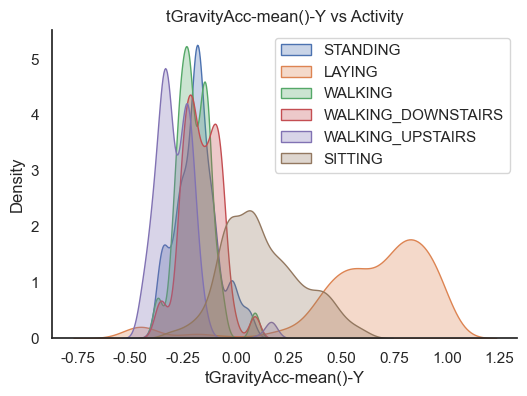

In [ ]:
# 4위: tGravityAcc-mean()-Y
plot_feature_kde(X_train, y_train, top_5_features[3])

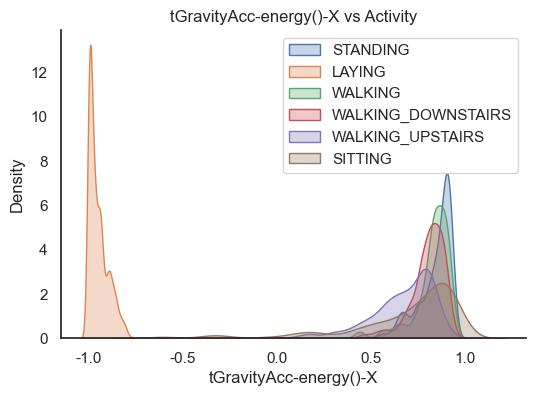

In [ ]:
# 5위: tGravityAcc-energy()-X 
plot_feature_kde(X_train, y_train, top_5_features[4])

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

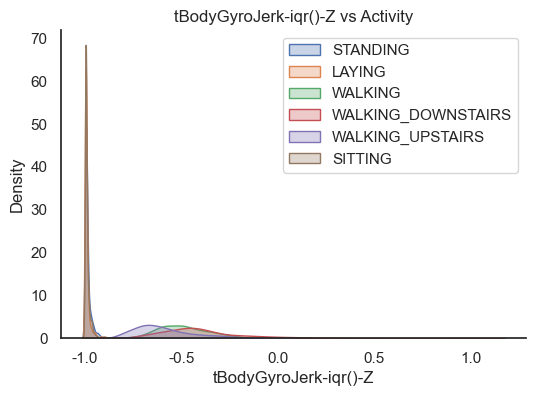

In [ ]:
# 1위 : tBodyGyroJerk-iqr()-Z
bottom_5_features = fi_df_sorted['feature_name'].tail(5).tolist()
plot_feature_kde(X_train, y_train, bottom_5_features[0])

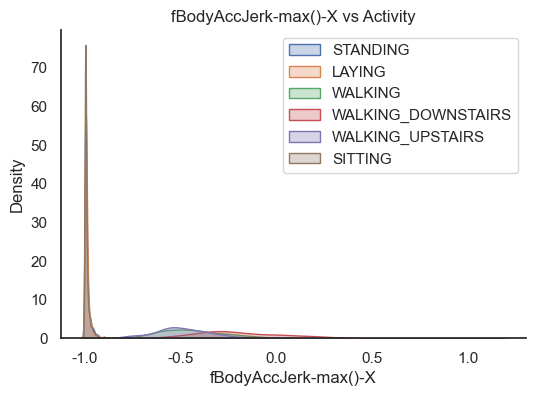

In [ ]:
# 2위: fBodyAccJerk-max()-X
plot_feature_kde(X_train, y_train, bottom_5_features[1])

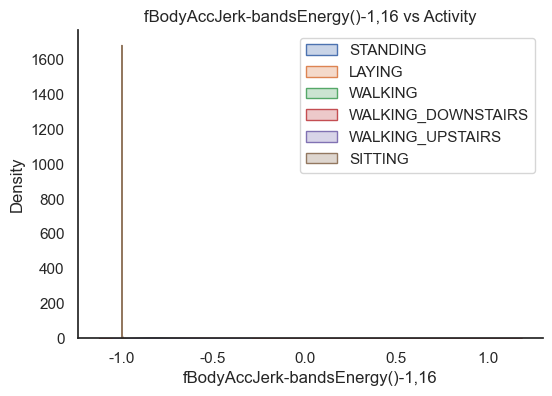

In [ ]:
# 3위: fBodyAccJerk-bandsEnergy()-1,16 
plot_feature_kde(X_train, y_train, bottom_5_features[2])

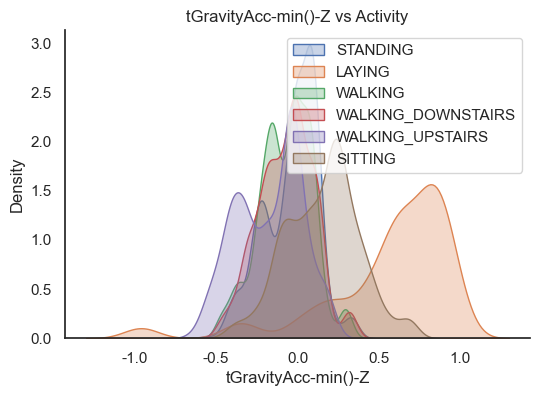

In [ ]:
# 4위: tGravityAcc-min()-Z     
plot_feature_kde(X_train, y_train, bottom_5_features[3])

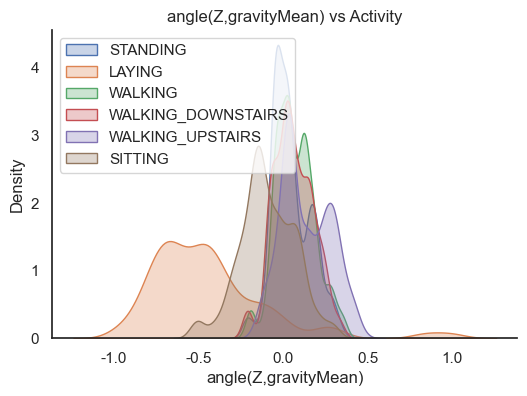

In [ ]:
# 5위: angle(Z,gravityMean)
plot_feature_kde(X_train, y_train, bottom_5_features[4])

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.


#### 1) is_dynamic 추가

In [ ]:
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)
dynamic_map = {
    'STANDING': 0,
    'SITTING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1
}

train_data['is_dynamic'] = train_data['Activity'].map(dynamic_map)
test_data['is_dynamic'] = test_data['Activity'].map(dynamic_map)

train_data['is_dynamic'].value_counts()

is_dynamic
0    3234
1    2647
Name: count, dtype: int64

#### 2) 기본모델 생성

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
X = train_data.drop(columns=['Activity','is_dynamic'])
y = train_data['is_dynamic']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y 
)

In [ ]:
#RandomForestClassifier로 모델링 진행
rf_model_dynamic = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_model_dynamic.fit(X_train, y_train)

y_pred = rf_model_dynamic.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Accuracy Score:", acc)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.9991503823279524
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 3) 변수중요도 상위 5개 분석

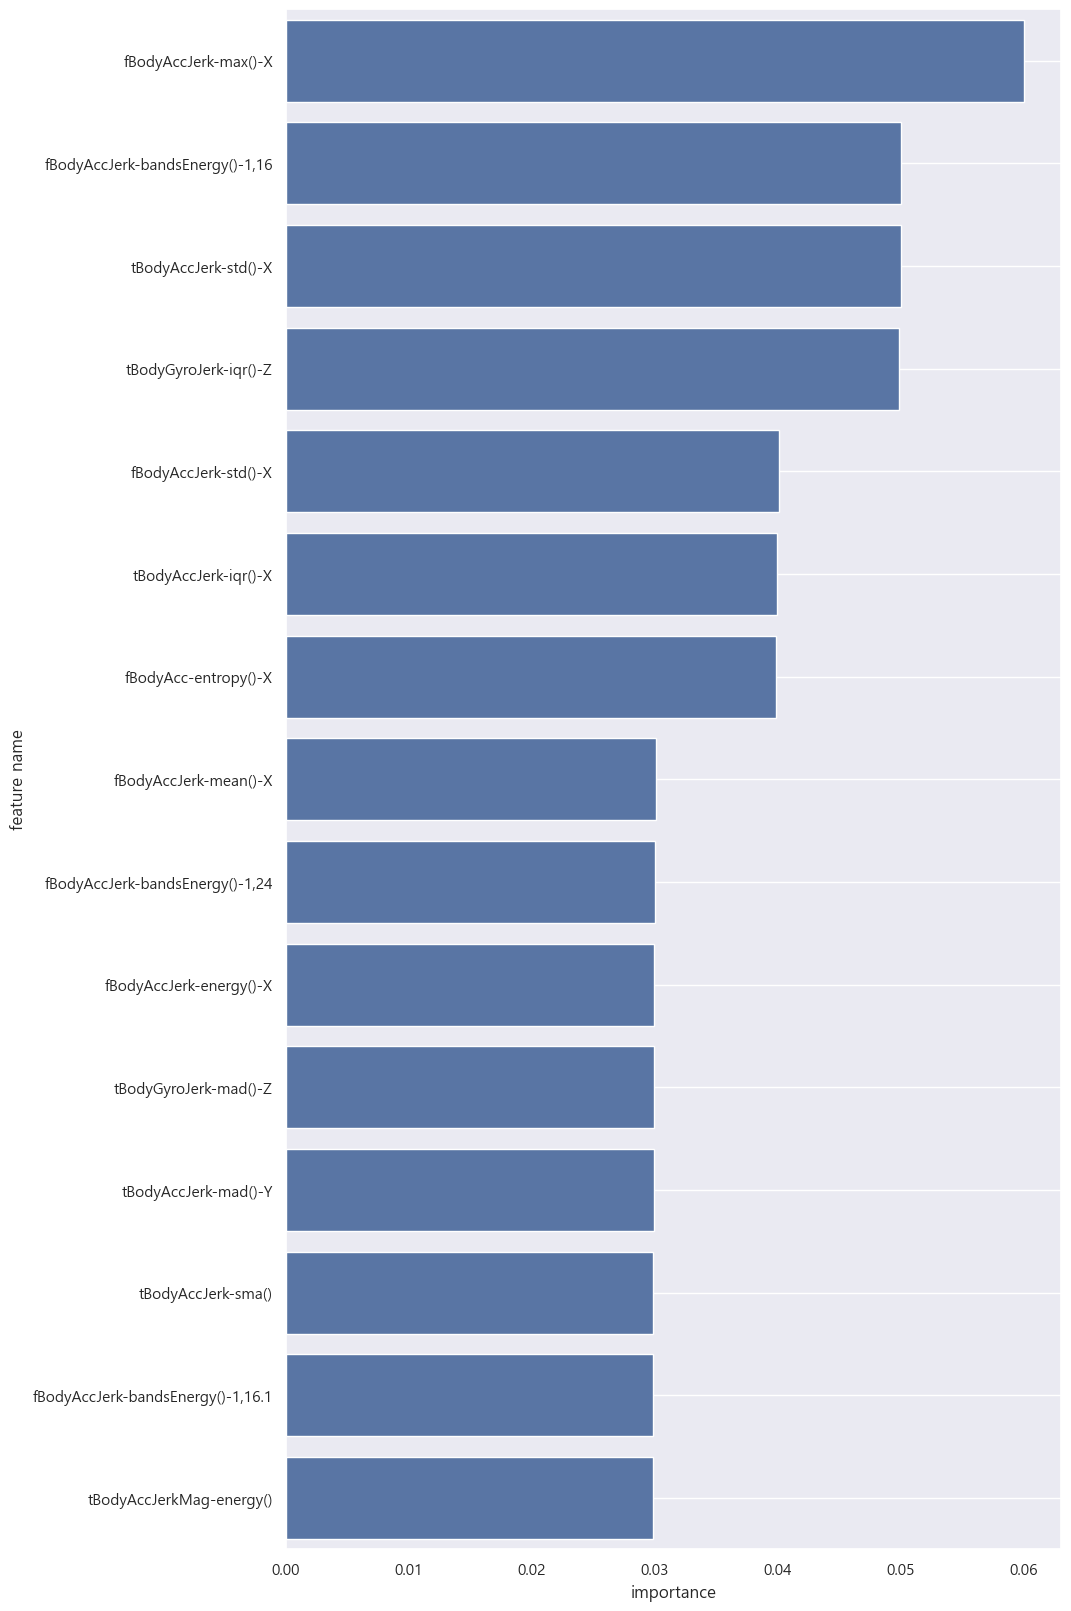

In [ ]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!
n_top = 15
feature_importances = rf_model_dynamic.feature_importances_
fi_df = plot_feature_importance(feature_importances, X_train.columns, topn=n_top)

In [ ]:
fi_df_sorted = fi_df.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)

print("상위 5개 feature:")
print(fi_df_sorted.head(5))

상위 5개 feature:
                      feature_name  feature_importance
0             fBodyAccJerk-max()-X            0.060009
1  fBodyAccJerk-bandsEnergy()-1,16            0.050000
2             tBodyAccJerk-std()-X            0.049991
3            tBodyGyroJerk-iqr()-Z            0.049863
4             fBodyAccJerk-std()-X            0.040118


* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

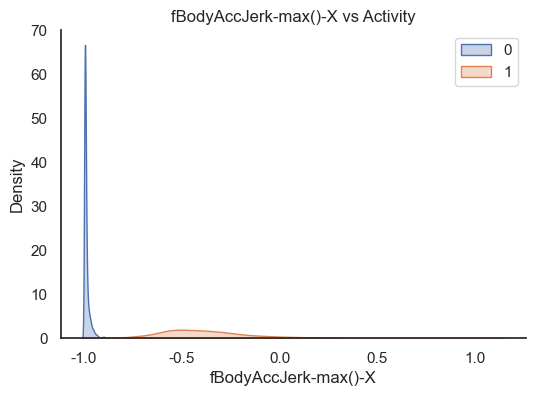

In [ ]:
# 1위: fBodyAccJerk-max()-X
top_5_features = fi_df_sorted['feature_name'].head(5).tolist()
plot_feature_kde(X_train, y_train, top_5_features[0])

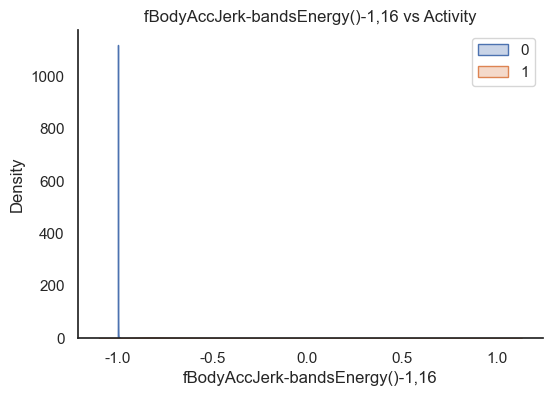

In [ ]:
# 2위: fBodyAccJerk-bandsEnergy()-1,16
plot_feature_kde(X_train, y_train, top_5_features[1])

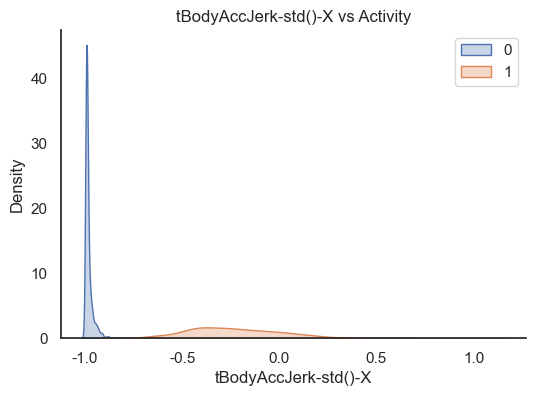

In [ ]:
# 3위: tBodyAccJerk-std()-X
plot_feature_kde(X_train, y_train, top_5_features[2])

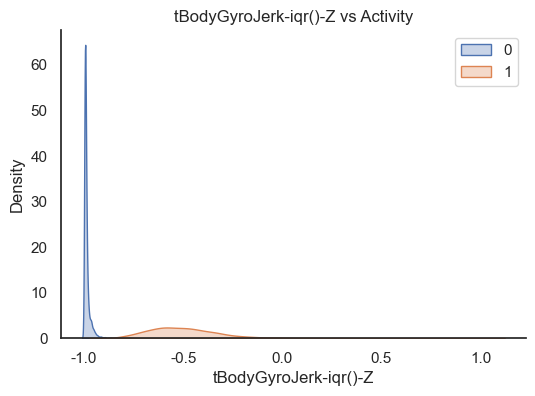

In [ ]:
# 4위: tBodyGyroJerk-iqr()-Z
plot_feature_kde(X_train, y_train, top_5_features[3])

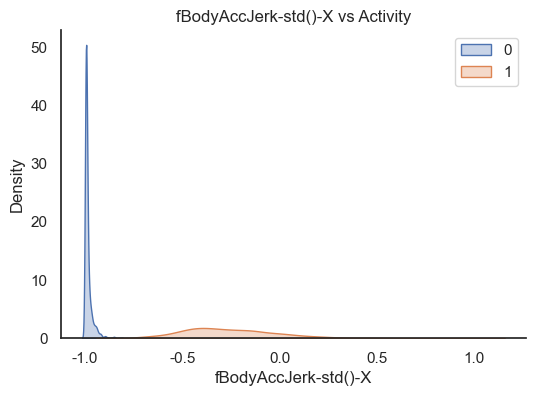

In [ ]:
# 5위: fBodyAccJerk-std()-X 
plot_feature_kde(X_train, y_train, top_5_features[4])

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [ ]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!
fi_activity = pd.DataFrame({
    'feature': X_train.columns,
    'importance_activity': rf_model_activity.feature_importances_
})

fi_dynamic = pd.DataFrame({
    'feature': X_train.columns,
    'importance_dynamic': rf_model_dynamic.feature_importances_ 
})

#### 2) 합치기

In [ ]:
# merge 해서 2개를 합치는 작업하기
fi_merged = pd.merge(fi_activity, fi_dynamic, on='feature', how='outer')
fi_merged.head()

,feature,importance_activity,importance_dynamic
0,"angle(X,gravityMean)",0.038026,0.000111
1,"angle(Y,gravityMean)",0.018810,0.000009
2,"angle(Z,gravityMean)",0.011381,0.000017
3,"angle(tBodyAccJerkMean),gravityMean)",0.000180,0.000000
4,"angle(tBodyAccMean,gravity)",0.000230,0.000000


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')
path = './results/'  # 저장할 폴더명
file_name = 'feature_importances_merged.pkl'
joblib.dump(fi_merged, path + file_name)

['./results/feature_importances_merged.pkl']

#### 고생하셨습니다! 이제 기본 모델링을 해봅시다.